In [1]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")
m5 = read_sbml_model("GEMs/M5_curated.xml")

## static sim

look into the possibilities for crossfeeding

## dynamic sim
sequential community

In [2]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

# TODO: calculate xylan (60 g/L concentration) to an amount of moles that makes sense
added_metabilotes["xylan4_e"] = 5
#added_metabilotes["xylan8_e"] = 10

#added_metabilotes["xyl__D_e"] = 2 #TODO: remove

INOC_TIME = 3

In [3]:
# NOTE: these param vals mean nothing, I am just testning something out
kinetic_params = {"NJ4": {"vmax": {"EX_xyl__D_e": 10}}, "M5": {"vmax": {"EX_xyl__D_e": 0.05, "xylan4_e": 0.1}}}

In [4]:
from utils import comets_functions as cf

first_sim, second_sim = cf.sequental_com(m5, nj4, init_medium=added_metabilotes, total_sim_time=10, inoc_time=INOC_TIME, initial_pop_m5=0.0001, kinetic_params=kinetic_params)

reaction couldnt be found

Running COMETS simulation ...
Done!
reaction couldnt be found

Running COMETS simulation ...
Done!


In [5]:
bm, met, fluxes = cf.collapse_sequential_sim(first_sim, second_sim)

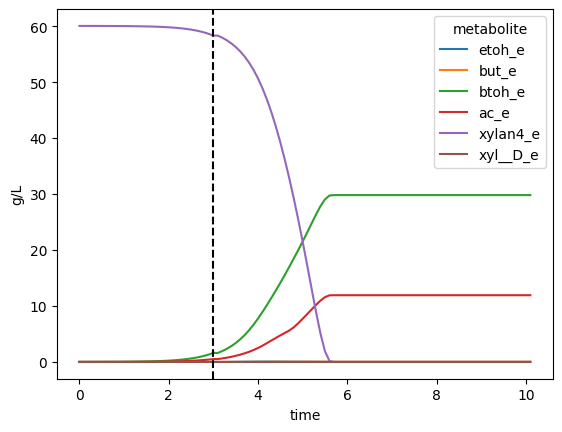

In [42]:
metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "xylan4_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME)

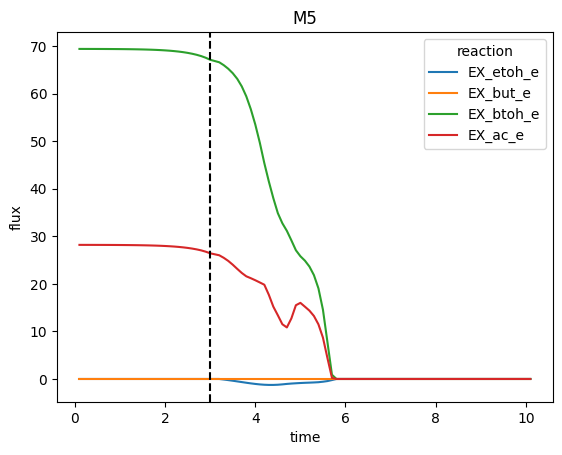

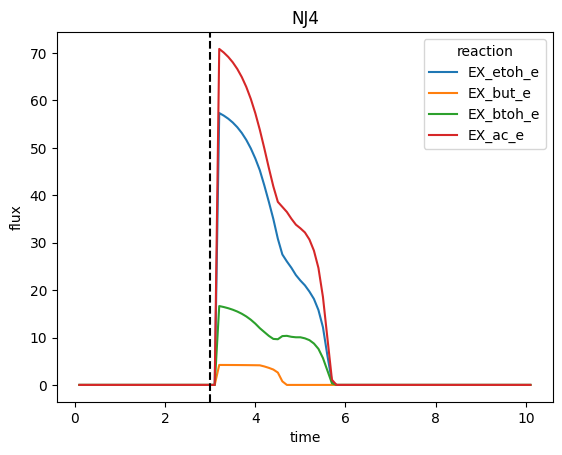

In [6]:
import matplotlib.pyplot as plt

production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e"]

cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('M5')
plt.show()

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('NJ4')
plt.show()

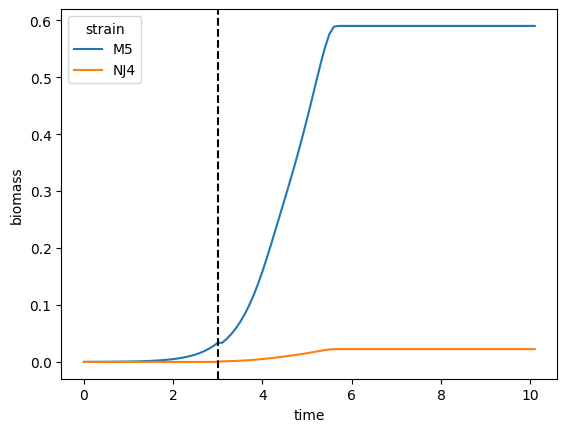

In [44]:
cf.plot_biomass(total_biomass=bm, inoc_time=INOC_TIME)

In [48]:
second_sim.get_species_exchange_fluxes("NJ4")

,cycle,EX_2hxmp_e,EX_3amp_e,EX_3cmp_e,EX_3gmp_e,EX_3mb_e,EX_3ump_e,EX_4abut_e,EX_4abz_e,EX_4ahmmp_e,...,EX_ura_e,EX_urea_e,EX_val__L_e,EX_xan_e,EX_xyl__D_e,EX_xylan4_e,EX_xylan8_e,EX_zn2_e,EX_btoh_e,EX_acetone_e
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.700406,0.0,0.0,0.0,0.0,-9.066453,-4.585948,-0.000722,16.638408,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.693124,0.0,0.0,0.0,0.0,-9.060956,-4.491349,-0.000715,16.431200,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.684197,0.0,0.0,0.0,0.0,-9.054249,-4.375359,-0.000705,16.177173,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.673247,0.0,0.0,0.0,0.0,-9.046059,-4.233079,-0.000694,15.865608,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.659820,0.0,0.0,0.0,0.0,-9.036053,-4.058597,-0.000680,15.483567,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
66,67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
67,68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
68,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [50]:
second_sim.get_species_exchange_fluxes("M5")

,cycle,EX_15dap_e,EX_2hxmp_e,EX_2m35mdntha_e,EX_2obut_e,EX_2pglyc_e,EX_35dnta_e,EX_3mb_e,EX_4abut_e,EX_4abutn_e,...,EX_udcpp_e,EX_ura_e,EX_val__L_e,EX_xyl3_e,EX_xyl__D_e,EX_xylan4_e,EX_xylan8_e,EX_xylb_e,EX_zn2_e,EX_btoh_e
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.527043,...,0.0,3.908222,0.0,0.0,0.0,-9.066453,-4.585948,0.0,-0.000699,66.601036
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.446694,...,0.0,3.823988,0.0,0.0,0.0,-9.060956,-4.491349,0.0,-0.000691,65.991047
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.348325,...,0.0,3.720838,0.0,0.0,0.0,-9.054249,-4.375359,0.0,-0.000681,65.236496
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.227850,...,0.0,3.594477,0.0,0.0,0.0,-9.046059,-4.233079,0.0,-0.000669,64.302457
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.215700,...,0.0,3.439762,0.0,0.0,0.0,-9.036053,-4.058597,0.0,-0.000655,63.109236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
66,67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
67,68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
68,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
